In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import os
from sklearn.preprocessing import RobustScaler

# 설정 변수
SYMBOL = 'BTCUSDT'

# 파일 경로
file_path = '/home/zero/test1/full_csv/BTCUSDT.csv'

def calculate_sma(df, window):
    return df.rolling(window=window).mean()

def calculate_bollinger_bands(df, window):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    bollinger_up = sma + (std * 2)
    bollinger_down = sma - (std * 2)
    return bollinger_up, bollinger_down

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # 시간 순서대로 정렬
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.sort_values(by='open_time', inplace=True)
    
    df.drop(columns=['open', 'high', 'low'], inplace=True)
    
    # SMA 및 볼린저 밴드 계산
    df['sma_20'] = calculate_sma(df['close'], 20)
    bollinger_up, bollinger_down = calculate_bollinger_bands(df['close'], 20)
    df['bollinger_up'] = bollinger_up
    df['bollinger_down'] = bollinger_down
    
    df['close_shift'] = df['close'].shift(+1)
    df['new_close'] = (df['close'] - df['close_shift']) / df['close_shift']
    
    # 가격 변동률 계산
    df['future_close'] = df['close'].shift(-3)
    
    # 가격 움직임 계산 ()
    def label_movement(row):
        if pd.isna(row['future_close']):
            return None
        if row['future_close'] > row['close'] * 1.0006:
            return 2
        elif row['future_close'] < row['close'] * 0.9994:
            return 1
        else:
            return 0
        
    df['movement'] = df.apply(label_movement, axis=1)
    df.dropna(inplace=True)
    df.drop(columns=['open_time','close','future_close','close_shift', 'symbol','quote_av','tb_base_av','tb_quote_av'], inplace=True)
    
    # RobustScaler 인스턴스 생성
    scaler = RobustScaler()

    # 데이터프레임에서 'movement' 컬럼을 제외한 수치형 컬럼 선택
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = numeric_cols.drop('movement')  # 'movement' 컬럼 제외

    # 수치형 컬럼에 대해 RobustScaler 적용
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    return df

df = load_and_preprocess_data(file_path)

In [82]:
movement_counts = df['movement'].value_counts()
print(movement_counts)

movement
0.0    832291
1.0    426552
2.0    425936
Name: count, dtype: int64


In [4]:
# # 전체 샘플 수와 각 클래스의 샘플 수
# n_samples_0 = 832291
# n_samples_1 = 426552
# n_samples_2 = 425936
# total_samples = n_samples_0 + n_samples_1 + n_samples_2

# # 각 클래스의 초기 가중치 계산
# initial_weight_0 = total_samples / (3 * n_samples_0)
# initial_weight_1 = total_samples / (3 * n_samples_1)
# initial_weight_2 = total_samples / (3 * n_samples_2)

# # 가중치 정규화
# weights_sum = initial_weight_0 + initial_weight_1 + initial_weight_2
# normalized_weight_0 = round((initial_weight_0 / weights_sum), 3)
# normalized_weight_1 = round((initial_weight_1 / weights_sum), 3)
# normalized_weight_2 = round((initial_weight_2 / weights_sum), 3)
# normalized_weight_0, normalized_weight_1, normalized_weight_2
class_weights = {0: 0.2, 1: 0.4, 2: 0.4}
class_weights

{0: 0.2, 1: 0.4, 2: 0.4}

In [5]:
real = ['volume', 'trades', 'sma_20', 'bollinger_up', 'bollinger_down', 'new_close', 'movement']
# 시퀀스 데이터 생성 함수
def create_sequences(df, seq_length):
    X, y = [], []
    data = df[real].values
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])  # price_change_ratio을 예측값으로 사용


    return np.array(X), np.array(y)

X, y = create_sequences(df, seq_length=20)

In [6]:
# 데이터 분할
# 데이터셋의 총 길이 계산
total_length = len(X)

# 학습 데이터와 테스트 데이터로 분할할 인덱스 계산
split_index = int(total_length * 0.8)

# 시계열 데이터를 시간 순서대로 분할
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training label shape: {y_train.shape}")

Training data shape: (1347807, 20, 6)
Test data shape: (336952, 20, 6)
Training label shape: (1347807,)


In [19]:
# import tensorflow as tf
# from tensorflow.keras.metrics import Metric

# class MulticlassF1Score(Metric):
#     def __init__(self, num_classes, name='multiclass_f1_score', **kwargs):
#         super(MulticlassF1Score, self).__init__(name=name, **kwargs)
#         self.num_classes = num_classes
#         self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
#         self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
#         self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.argmax(y_pred, axis=1)
#         y_true = tf.cast(y_true, tf.int32)

#         # 각 클래스별로 true positives, false positives, false negatives를 계산
#         for class_id in range(self.num_classes):
#             # 현재 클래스에 대한 true/false positives/negatives를 찾습니다.
#             tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, class_id), tf.equal(y_pred, class_id)), tf.float32))
#             fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, class_id), tf.equal(y_pred, class_id)), tf.float32))
#             fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, class_id), tf.not_equal(y_pred, class_id)), tf.float32))

#             # 업데이트 인덱스 및 값 생성
#             indices = tf.reshape([class_id], [1, 1])
#             tp_updates = tf.reshape(tp, [1])
#             fp_updates = tf.reshape(fp, [1])
#             fn_updates = tf.reshape(fn, [1])

#             # tf.tensor_scatter_nd_add를 사용하여 가중치를 업데이트
#             self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, indices, tp_updates))
#             self.false_positives.assign(tf.tensor_scatter_nd_add(self.false_positives, indices, fp_updates))
#             self.false_negatives.assign(tf.tensor_scatter_nd_add(self.false_negatives, indices, fn_updates))


#     def result(self):
#         precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
#         recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
#         f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
#         macro_f1_score = tf.reduce_mean(f1_score)
#         return macro_f1_score

#     def reset_state(self):
#         for i in range(self.num_classes):
#             self.true_positives[i].assign(0)
#             self.false_positives[i].assign(0)
#             self.false_negatives[i].assign(0)

In [37]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric
# MulticlassF1Score 클래스 정의
class MulticlassF1Score(Metric):
    def __init__(self, num_classes, name='multiclass_f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int32)
        
        for class_id in range(self.num_classes):
            tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, class_id), tf.equal(y_pred, class_id)), tf.float32))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, class_id), tf.equal(y_pred, class_id)), tf.float32))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, class_id), tf.not_equal(y_pred, class_id)), tf.float32))

            self.true_positives.assign_add(tf.tensor_scatter_nd_add(self.true_positives, [[class_id]], [tp]))
            self.false_positives.assign_add(tf.tensor_scatter_nd_add(self.false_positives, [[class_id]], [fp]))
            self.false_negatives.assign_add(tf.tensor_scatter_nd_add(self.false_negatives, [[class_id]], [fn]))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        macro_f1_score = tf.reduce_mean(f1_score)
        return macro_f1_score

    def reset_state(self):
        for i in range(self.num_classes):
            self.true_positives[i].assign(0)
            self.false_positives[i].assign(0)
            self.false_negatives[i].assign(0)
            
    def get_config(self):
        config = super().get_config()
        config['num_classes'] = self.num_classes
        return config

    @classmethod
    def from_config(cls, config):
        # 수정된 from_config 메서드
        return cls(**config)

In [20]:
num_classes = 3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(20, 6))

# CNN 레이어
cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(filters=128, kernel_size=3, activation='relu')(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)


# LSTM 층
lst = LSTM(50)(cnn)  
lst = Dropout(0.3)(lst)

# Dense 층
dd = Dense(50, activation='relu')(lst)
dd = Dropout(0.3)(dd)

# 출력 층
outputs = Dense(3, activation='softmax')(dd)

model = Model(inputs=input_layer, outputs=outputs)

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', MulticlassF1Score(num_classes)])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 18, 64)            1216      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 3, 128)            0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 64)             2464

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='/home/zero/test1/one_preprocess_4(model)/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}',  
    monitor='val_accuracy',  
    save_best_only=False, 
    save_weights_only=False, 
    verbose=1  
)

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=7,         
    verbose=1,          
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping,model_checkpoint],
    verbose=1
)

Epoch 1/30
10530/10530 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.4466 - multiclass_f1_score: 0.3290

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_01_val_accuracy_0.65
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_01_val_accuracy_0.65/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_01_val_accuracy_0.65/assets


10530/10530 [==============================] - 112s 10ms/step - loss: 0.3202 - accuracy: 0.4466 - multiclass_f1_score: 0.3290 - val_loss: 0.8454 - val_accuracy: 0.6462 - val_multiclass_f1_score: 0.4195
Epoch 2/30
   12/10530 [..............................] - ETA: 1:49 - loss: 0.3165 - accuracy: 0.4564 - multiclass_f1_score: 0.3225

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.4498 - multiclass_f1_score: 0.3289
Epoch 2: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_02_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_02_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_02_val_accuracy_0.64/assets


10530/10530 [==============================] - 116s 11ms/step - loss: 0.3194 - accuracy: 0.4498 - multiclass_f1_score: 0.3289 - val_loss: 0.8369 - val_accuracy: 0.6390 - val_multiclass_f1_score: 0.4273
Epoch 3/30
   13/10530 [..............................] - ETA: 1:33 - loss: 0.3219 - accuracy: 0.4297 - multiclass_f1_score: 0.3277

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3191 - accuracy: 0.4501 - multiclass_f1_score: 0.3286
Epoch 3: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_03_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_03_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_03_val_accuracy_0.64/assets


10530/10530 [==============================] - 114s 11ms/step - loss: 0.3191 - accuracy: 0.4501 - multiclass_f1_score: 0.3286 - val_loss: 0.8783 - val_accuracy: 0.6442 - val_multiclass_f1_score: 0.4220
Epoch 4/30
   14/10530 [..............................] - ETA: 1:26 - loss: 0.3172 - accuracy: 0.4799 - multiclass_f1_score: 0.3215

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10525/10530 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.4503 - multiclass_f1_score: 0.3285
Epoch 4: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_04_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_04_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_04_val_accuracy_0.64/assets


10530/10530 [==============================] - 113s 11ms/step - loss: 0.3190 - accuracy: 0.4502 - multiclass_f1_score: 0.3285 - val_loss: 0.8518 - val_accuracy: 0.6386 - val_multiclass_f1_score: 0.4250
Epoch 5/30
   14/10530 [..............................] - ETA: 1:30 - loss: 0.3166 - accuracy: 0.4643 - multiclass_f1_score: 0.3280

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10527/10530 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.4507 - multiclass_f1_score: 0.3281
Epoch 5: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_05_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_05_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_05_val_accuracy_0.64/assets


10530/10530 [==============================] - 115s 11ms/step - loss: 0.3189 - accuracy: 0.4507 - multiclass_f1_score: 0.3281 - val_loss: 0.8480 - val_accuracy: 0.6377 - val_multiclass_f1_score: 0.4287
Epoch 6/30
   13/10530 [..............................] - ETA: 1:36 - loss: 0.3191 - accuracy: 0.4573 - multiclass_f1_score: 0.3282

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.4505 - multiclass_f1_score: 0.3281
Epoch 6: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_06_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_06_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_06_val_accuracy_0.64/assets


10530/10530 [==============================] - 114s 11ms/step - loss: 0.3188 - accuracy: 0.4505 - multiclass_f1_score: 0.3281 - val_loss: 0.8367 - val_accuracy: 0.6434 - val_multiclass_f1_score: 0.4240
Epoch 7/30
   13/10530 [..............................] - ETA: 1:37 - loss: 0.3192 - accuracy: 0.4363 - multiclass_f1_score: 0.3267

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.4508 - multiclass_f1_score: 0.3280
Epoch 7: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_07_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_07_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_07_val_accuracy_0.64/assets


10530/10530 [==============================] - 114s 11ms/step - loss: 0.3186 - accuracy: 0.4508 - multiclass_f1_score: 0.3280 - val_loss: 0.8431 - val_accuracy: 0.6394 - val_multiclass_f1_score: 0.4278
Epoch 8/30
   13/10530 [..............................] - ETA: 1:38 - loss: 0.3091 - accuracy: 0.4886 - multiclass_f1_score: 0.3283

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.4512 - multiclass_f1_score: 0.3280
Epoch 8: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_08_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_08_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_08_val_accuracy_0.63/assets


10530/10530 [==============================] - 113s 11ms/step - loss: 0.3186 - accuracy: 0.4512 - multiclass_f1_score: 0.3280 - val_loss: 0.8668 - val_accuracy: 0.6313 - val_multiclass_f1_score: 0.4290
Epoch 9/30
   14/10530 [..............................] - ETA: 1:25 - loss: 0.3163 - accuracy: 0.4715 - multiclass_f1_score: 0.3271

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10524/10530 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.4514 - multiclass_f1_score: 0.3277
Epoch 9: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_09_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_09_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_09_val_accuracy_0.63/assets


10530/10530 [==============================] - 110s 10ms/step - loss: 0.3185 - accuracy: 0.4514 - multiclass_f1_score: 0.3277 - val_loss: 0.8366 - val_accuracy: 0.6339 - val_multiclass_f1_score: 0.4249
Epoch 10/30
   14/10530 [..............................] - ETA: 1:33 - loss: 0.3166 - accuracy: 0.4515 - multiclass_f1_score: 0.3213

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10529/10530 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.4516 - multiclass_f1_score: 0.3277
Epoch 10: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_10_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_10_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_10_val_accuracy_0.63/assets


10530/10530 [==============================] - 112s 11ms/step - loss: 0.3184 - accuracy: 0.4516 - multiclass_f1_score: 0.3277 - val_loss: 0.8409 - val_accuracy: 0.6296 - val_multiclass_f1_score: 0.4283
Epoch 11/30
   12/10530 [..............................] - ETA: 1:39 - loss: 0.3195 - accuracy: 0.4460 - multiclass_f1_score: 0.3207

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10530/10530 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.4517 - multiclass_f1_score: 0.3277
Epoch 11: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_11_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_11_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_11_val_accuracy_0.64/assets


10530/10530 [==============================] - 111s 11ms/step - loss: 0.3183 - accuracy: 0.4517 - multiclass_f1_score: 0.3277 - val_loss: 0.8354 - val_accuracy: 0.6404 - val_multiclass_f1_score: 0.4256
Epoch 12/30
   13/10530 [..............................] - ETA: 1:39 - loss: 0.3217 - accuracy: 0.4471 - multiclass_f1_score: 0.3234

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.4528 - multiclass_f1_score: 0.3278
Epoch 12: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_12_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_12_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_12_val_accuracy_0.64/assets


10530/10530 [==============================] - 111s 10ms/step - loss: 0.3182 - accuracy: 0.4528 - multiclass_f1_score: 0.3278 - val_loss: 0.8475 - val_accuracy: 0.6365 - val_multiclass_f1_score: 0.4253
Epoch 13/30
   12/10530 [..............................] - ETA: 1:39 - loss: 0.3126 - accuracy: 0.4727 - multiclass_f1_score: 0.3270

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10525/10530 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.4524 - multiclass_f1_score: 0.3275
Epoch 13: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_13_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_13_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_13_val_accuracy_0.63/assets


10530/10530 [==============================] - 108s 10ms/step - loss: 0.3182 - accuracy: 0.4524 - multiclass_f1_score: 0.3275 - val_loss: 0.8389 - val_accuracy: 0.6322 - val_multiclass_f1_score: 0.4221
Epoch 14/30
   14/10530 [..............................] - ETA: 1:25 - loss: 0.3158 - accuracy: 0.4481 - multiclass_f1_score: 0.3173

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.4519 - multiclass_f1_score: 0.3274
Epoch 14: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_14_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_14_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_14_val_accuracy_0.63/assets


10530/10530 [==============================] - 112s 11ms/step - loss: 0.3181 - accuracy: 0.4519 - multiclass_f1_score: 0.3274 - val_loss: 0.8419 - val_accuracy: 0.6325 - val_multiclass_f1_score: 0.4294
Epoch 15/30
   12/10530 [..............................] - ETA: 1:45 - loss: 0.3199 - accuracy: 0.4414 - multiclass_f1_score: 0.3270

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10530/10530 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.4529 - multiclass_f1_score: 0.3275
Epoch 15: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_15_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_15_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_15_val_accuracy_0.64/assets


10530/10530 [==============================] - 112s 11ms/step - loss: 0.3180 - accuracy: 0.4529 - multiclass_f1_score: 0.3275 - val_loss: 0.8456 - val_accuracy: 0.6384 - val_multiclass_f1_score: 0.4275
Epoch 16/30
   11/10530 [..............................] - ETA: 1:54 - loss: 0.3178 - accuracy: 0.4446 - multiclass_f1_score: 0.3291

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10527/10530 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.4535 - multiclass_f1_score: 0.3275
Epoch 16: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_16_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_16_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_16_val_accuracy_0.63/assets


10530/10530 [==============================] - 110s 10ms/step - loss: 0.3179 - accuracy: 0.4535 - multiclass_f1_score: 0.3275 - val_loss: 0.8562 - val_accuracy: 0.6298 - val_multiclass_f1_score: 0.4271
Epoch 17/30
   12/10530 [..............................] - ETA: 1:41 - loss: 0.3156 - accuracy: 0.4538 - multiclass_f1_score: 0.3208

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10527/10530 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.4528 - multiclass_f1_score: 0.3272
Epoch 17: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_17_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_17_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_17_val_accuracy_0.63/assets


10530/10530 [==============================] - 110s 10ms/step - loss: 0.3179 - accuracy: 0.4528 - multiclass_f1_score: 0.3272 - val_loss: 0.8571 - val_accuracy: 0.6333 - val_multiclass_f1_score: 0.4288
Epoch 18/30
   13/10530 [..............................] - ETA: 1:42 - loss: 0.3169 - accuracy: 0.4561 - multiclass_f1_score: 0.3293

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.4529 - multiclass_f1_score: 0.3271
Epoch 18: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_18_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_18_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_18_val_accuracy_0.64/assets


10530/10530 [==============================] - 110s 10ms/step - loss: 0.3178 - accuracy: 0.4528 - multiclass_f1_score: 0.3271 - val_loss: 0.8334 - val_accuracy: 0.6352 - val_multiclass_f1_score: 0.4289
Epoch 19/30
   13/10530 [..............................] - ETA: 1:28 - loss: 0.3156 - accuracy: 0.4513 - multiclass_f1_score: 0.3226

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.4537 - multiclass_f1_score: 0.3271
Epoch 19: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_19_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_19_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_19_val_accuracy_0.64/assets


10530/10530 [==============================] - 112s 11ms/step - loss: 0.3177 - accuracy: 0.4537 - multiclass_f1_score: 0.3271 - val_loss: 0.8457 - val_accuracy: 0.6368 - val_multiclass_f1_score: 0.4228
Epoch 20/30
   15/10530 [..............................] - ETA: 1:22 - loss: 0.3171 - accuracy: 0.4583 - multiclass_f1_score: 0.3239

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10529/10530 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.4534 - multiclass_f1_score: 0.3269
Epoch 20: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_20_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_20_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_20_val_accuracy_0.63/assets


10530/10530 [==============================] - 112s 11ms/step - loss: 0.3177 - accuracy: 0.4534 - multiclass_f1_score: 0.3269 - val_loss: 0.8480 - val_accuracy: 0.6283 - val_multiclass_f1_score: 0.4300
Epoch 21/30
   13/10530 [..............................] - ETA: 1:38 - loss: 0.3228 - accuracy: 0.4447 - multiclass_f1_score: 0.3287

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.4535 - multiclass_f1_score: 0.3271
Epoch 21: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_21_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_21_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_21_val_accuracy_0.64/assets


10530/10530 [==============================] - 111s 10ms/step - loss: 0.3176 - accuracy: 0.4535 - multiclass_f1_score: 0.3271 - val_loss: 0.8295 - val_accuracy: 0.6416 - val_multiclass_f1_score: 0.4268
Epoch 22/30
   12/10530 [..............................] - ETA: 1:38 - loss: 0.3163 - accuracy: 0.4453 - multiclass_f1_score: 0.3270

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.4534 - multiclass_f1_score: 0.3269
Epoch 22: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_22_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_22_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_22_val_accuracy_0.63/assets


10530/10530 [==============================] - 110s 10ms/step - loss: 0.3175 - accuracy: 0.4534 - multiclass_f1_score: 0.3269 - val_loss: 0.8337 - val_accuracy: 0.6327 - val_multiclass_f1_score: 0.4262
Epoch 23/30
   12/10530 [..............................] - ETA: 1:37 - loss: 0.3169 - accuracy: 0.4603 - multiclass_f1_score: 0.3242

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10524/10530 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.4537 - multiclass_f1_score: 0.3267
Epoch 23: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_23_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_23_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_23_val_accuracy_0.63/assets


10530/10530 [==============================] - 113s 11ms/step - loss: 0.3175 - accuracy: 0.4537 - multiclass_f1_score: 0.3267 - val_loss: 0.8513 - val_accuracy: 0.6340 - val_multiclass_f1_score: 0.4294
Epoch 24/30
   14/10530 [..............................] - ETA: 1:30 - loss: 0.3165 - accuracy: 0.4576 - multiclass_f1_score: 0.3264

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10525/10530 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.4542 - multiclass_f1_score: 0.3268
Epoch 24: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_24_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_24_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_24_val_accuracy_0.63/assets


10530/10530 [==============================] - 108s 10ms/step - loss: 0.3174 - accuracy: 0.4542 - multiclass_f1_score: 0.3268 - val_loss: 0.8575 - val_accuracy: 0.6307 - val_multiclass_f1_score: 0.4299
Epoch 25/30
   14/10530 [..............................] - ETA: 1:32 - loss: 0.3181 - accuracy: 0.4464 - multiclass_f1_score: 0.3244

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10526/10530 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.4544 - multiclass_f1_score: 0.3267
Epoch 25: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_25_val_accuracy_0.62
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_25_val_accuracy_0.62/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_25_val_accuracy_0.62/assets


10530/10530 [==============================] - 121s 11ms/step - loss: 0.3174 - accuracy: 0.4544 - multiclass_f1_score: 0.3267 - val_loss: 0.8583 - val_accuracy: 0.6242 - val_multiclass_f1_score: 0.4297
Epoch 26/30
   10/10530 [..............................] - ETA: 2:06 - loss: 0.3192 - accuracy: 0.4500 - multiclass_f1_score: 0.3230

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.4542 - multiclass_f1_score: 0.3264
Epoch 26: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_26_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_26_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_26_val_accuracy_0.64/assets


10530/10530 [==============================] - 124s 12ms/step - loss: 0.3173 - accuracy: 0.4542 - multiclass_f1_score: 0.3264 - val_loss: 0.8334 - val_accuracy: 0.6382 - val_multiclass_f1_score: 0.4276
Epoch 27/30
    6/10530 [..............................] - ETA: 2:03 - loss: 0.3267 - accuracy: 0.4440 - multiclass_f1_score: 0.3301

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10529/10530 [============================>.] - ETA: 0s - loss: 0.3172 - accuracy: 0.4543 - multiclass_f1_score: 0.3266
Epoch 27: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_27_val_accuracy_0.64
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_27_val_accuracy_0.64/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_27_val_accuracy_0.64/assets


10530/10530 [==============================] - 116s 11ms/step - loss: 0.3172 - accuracy: 0.4543 - multiclass_f1_score: 0.3266 - val_loss: 0.8379 - val_accuracy: 0.6358 - val_multiclass_f1_score: 0.4278
Epoch 28/30
   14/10530 [..............................] - ETA: 1:33 - loss: 0.3200 - accuracy: 0.4531 - multiclass_f1_score: 0.3262

/home/zero/.local/lib/python3.10/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric MulticlassF1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


10528/10530 [============================>.] - ETA: 0s - loss: 0.3172 - accuracy: 0.4540 - multiclass_f1_score: 0.3263Restoring model weights from the end of the best epoch: 21.

Epoch 28: saving model to /home/zero/test1/one_preprocess_4(model)/model_epoch_28_val_accuracy_0.63
INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_28_val_accuracy_0.63/assets


INFO:tensorflow:Assets written to: /home/zero/test1/one_preprocess_4(model)/model_epoch_28_val_accuracy_0.63/assets


10530/10530 [==============================] - 121s 11ms/step - loss: 0.3172 - accuracy: 0.4540 - multiclass_f1_score: 0.3263 - val_loss: 0.8339 - val_accuracy: 0.6311 - val_multiclass_f1_score: 0.4284
Epoch 28: early stopping


10530/10530 [==============================] - 22s 2ms/step


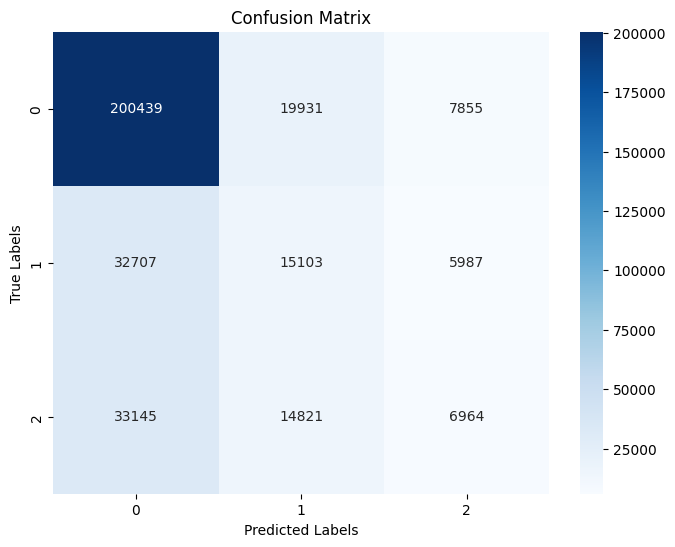

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 모델 예측
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [41]:
cm

array([[200439,  19931,   7855],
       [ 32707,  15103,   5987],
       [ 33145,  14821,   6964]])

In [43]:
# 클래스별 개수 계산
unique, counts = np.unique(y_test, return_counts=True)
class_counts = dict(zip(unique, counts))

class_counts

{0.0: 228225, 1.0: 53797, 2.0: 54930}

In [44]:
# 클래스별 개수 계산
unique, counts = np.unique(y_pred, return_counts=True)
class_counts = dict(zip(unique, counts))

class_counts

{0: 266291, 1: 49855, 2: 20806}

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from tensorflow.keras.models import load_model

# 모델이 저장된 기본 경로
base_path = '/home/zero/test1/one_preprocess_4(model)/'

# 해당 경로에 있는 모든 항목을 리스트업
all_files = os.listdir(base_path)

# 모델 파일(또는 디렉토리)만 필터링
model_files = [file for file in all_files if file.startswith('model_epoch')]

# 각 모델 파일(또는 디렉토리)에 대해 반복
for model_file in model_files:
    # 모델 경로 조합
    model_path = os.path.join(base_path, model_file)
    
    # 모델 불러오기
    model = load_model(model_path, custom_objects={'MulticlassF1Score': MulticlassF1Score})
    
    # 모델을 사용하여 예측 수행
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_test, predicted_classes)
    
    # 결과 출력
    print(f"Model: {model_file}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")
    # 클래스 별 정밀도 계산
    precision_1 = (precision_score(y_test, predicted_classes, labels=[1], average='micro')).round(4)
    precision_2 = (precision_score(y_test, predicted_classes, labels=[2], average='micro')).round(4)

    print(precision_1, precision_2)

In [22]:
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_score


# 폴더 경로 지정
model_directory = '/home/zero/test1/one_preprocess_4(model)/'

# 폴더 내 모든 .h5 파일 목록 가져오기
model_files = [f for f in os.listdir(model_directory) if f.endswith('.h5')]

for model_file in model_files:
    # 모델 불러오기
    model_path = os.path.join(model_directory, model_file)
    model = tf.keras.models.load_model(model_path)
    
    # 모델을 사용하여 예측 수행
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_test, predicted_classes)
    
    # 결과 출력
    print(f"Model: {model_file}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")
    # 클래스 별 정밀도 계산
    precision_1 = (precision_score(y_test, predicted_classes, labels=[1], average='micro')).round(4)
    precision_2 = (precision_score(y_test, predicted_classes, labels=[2], average='micro')).round(4)

    print(precision_1, precision_2)


10530/10530 [==============================] - 22s 2ms/step
Model: model_epoch_01_val_accuracy_0.66.h5
Confusion Matrix:
[[200439  19931   7855]
 [ 32707  15103   5987]
 [ 33145  14821   6964]]


0 0


In [1]:
from tensorflow.keras.models import load_model
model = load_model(f'/home/zero/test1/one_preprocess_4(model)/model_epoch_01_val_accuracy_0.66.h5')

2024-02-21 08:32:49.091485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 08:32:51.445466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 08:32:51.542331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 08:32:51.542377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu